# Automating Traditional Machine Learning with WANDB
featuring `pandas-profiling`, `pycaret`, `evidently`, and `fastapi`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1KyvD4ZypfwWPC90YqRlEqQnRZ2d9_OFM)

---

## What is AutoML?

AutoML automates the most time-consuming tasks of machine learning model development, allowing data scientists to train effective models more quickly. Traditionally, building a model has required domain expertise and time consuming iteration. AutoML accelerates this process.

The advantages of AutoML can be summed up in three major points:
- Increases productivity by automating repetitive tasks. This enables a data scientist to focus more on the problem rather than the models.
- Automating the ML pipeline also helps to avoid errors that might creep in manually.
- Ultimately, AutoML is a step towards democratizing machine learning by making the power of ML accessible to everybody.

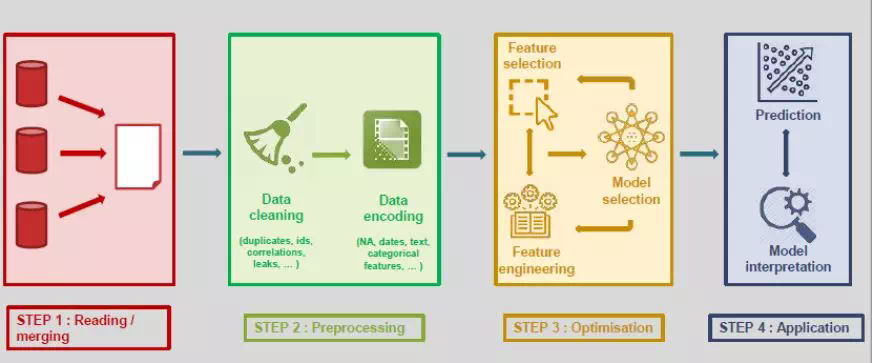

---

## Notebook TOC

We will be showing different aspects of automation we can add alongside flexible MLOPs tools. 

W&B is the best choice for our use case due to its data artifacts with lineaging, interactive data driven reports (which can be orchestrated to update as our models and experiments expand), metadata capabilties for orchestration, and flexibility to add in these capabilities in a low code no setup fashion.

1. [Adding easy, automatic Data Lineage for data artifacts via W&B and a prepared dataset. Alongside `pandas-profiling` which will automate a lot of the EDA process and provide an artifact for which we can refer to at any time for this dataset, which can be passed to colleagues](#1)

2. [Adding low code, automatic model training and hyperparameter optimization which picks latest data artfiacts from W&B, marks it as an input to the `PyCaret` experiment we will run, and then train, analyze, and generate model artifacts to evaluate on for production purposes in W&B](#2)

3. [Simulate analyzing possible data drift/model drift on data by using `Evidently` to analyze simulated incoming "production" data with ground truth. Using this "production" data we calculate a variety of metrics and assign it to the W&B metadata of the model which can be used as a selector of the best model artifacts](#3)

4. [Use the W&B metadata and a selected metric to search through the model candidates and promote the model which has the best selected metric. In this case the promotion tag we hard-code is "production"](#4)

5. [(optional) Do things with your production model! Load the model easily to flexibly do things such as serve a prediction endpoint in a backend framework of your choice.](#5)

# Code

In [ ]:
#Use bash to install all the necessary packages
!pip install -qqq wandb pycaret shap evidently

In [ ]:
!pip install -qqq pyyaml==5.4.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
evidently 0.1.31.dev0 requires PyYAML~=6.0, but you have pyyaml 5.4.1 which is incompatible.


In [ ]:
# from pycaret.utils import enable_colab 
# enable_colab()

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: a-sh0ts (use `wandb login --relogin` to force relogin)


True

### General Accessory Functions

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def prep_pandas_for_wandb(df):
    return df.convert_dtypes().fillna(np.nan).replace([np.nan], [None])
def pandas_to_wandb(df):
    return wandb.Table(dataframe=prep_pandas_for_wandb(df))

In [ ]:
def load_wandb_table_artifact(table_path):
  table_w_meta = json.load(open(table_path))
  table = pd.DataFrame(table_w_meta["data"], columns=table_w_meta["columns"])
  return table

<a name="1"></a>
## 1: Data Artifacts with W&B and Pandas Profiling

### [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling)

Generates profile reports from a pandas `DataFrame`. 

>The pandas `df.describe()` function is great but a little basic for serious exploratory data analysis. 
`pandas_profiling` extends the pandas DataFrame with `df.profile_report()` for quick data analysis.

For each column the following statistics - if relevant for the column type - are presented in an interactive HTML report:

* **Type inference**: detect the types of columns in a dataframe.
* **Essentials**: type, unique values, missing values
* **Quantile statistics** like minimum value, Q1, median, Q3, maximum, range, interquartile range
* **Descriptive statistics** like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
* **Most frequent values**
* **Histogram**
* **Correlations** highlighting of highly correlated variables, Spearman, Pearson and Kendall matrices
* **Missing values** matrix, count, heatmap and dendrogram of missing values
* **Text analysis** learn about categories (Uppercase, Space), scripts (Latin, Cyrillic) and blocks (ASCII) of text data.
* **File and Image analysis** extract file sizes, creation dates and dimensions and scan for truncated images or those containing EXIF information.

In [ ]:
## Common data splitting function with some hard coded parameters
# We use this to split the data into training and "production" data for our evaluation later
def sample_split_data(dataset, seed=1):
    data = dataset.sample(frac=0.95, random_state=seed)
    data_unseen = dataset.drop(data.index)

    data.reset_index(inplace=True, drop=True)
    data_unseen.reset_index(inplace=True, drop=True)

    print('Data for Modeling: ' + str(data.shape))
    print('Unseen Data For Predictions ' + str(data_unseen.shape))

    return (data, data_unseen)

In our example we will be finding ourselves utilizing our data pool for 3 general categories of data batches we may interact with as an ML practictioner: 
- Training Data
- Validation Data
- "Production" Unseen Data

In our case our package of choice `pycaret` will be handling the partitioning of data into training and validation from a pool of provided data (the data for modeling)

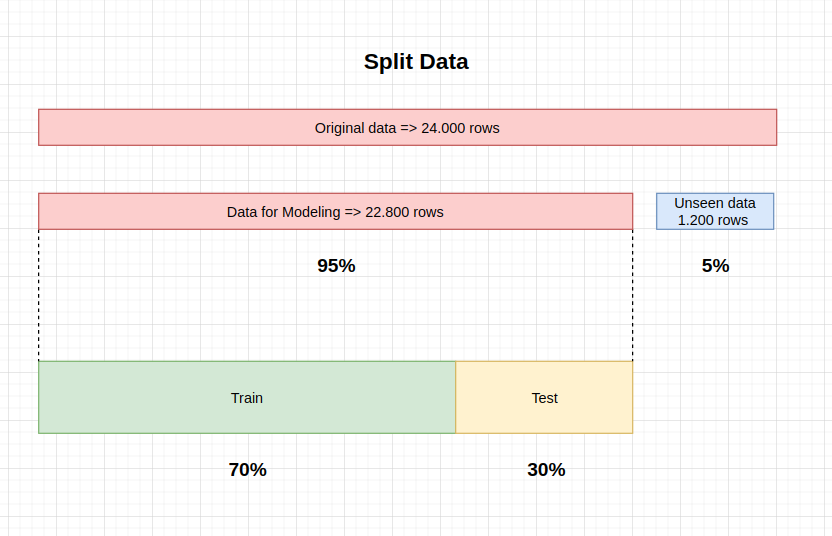

In [ ]:
from pandas_profiling import ProfileReport

# Here we just clean up things to make it more easy to automate how our output will look like in W&B
def generate_pandas_wandb_artifact(df, artifact_type, artifact_name=None, profile=True, profile_full_name="df.html"):
  if artifact_name:
    artifact_full_name = f"{artifact_name}_{artifact_type}_data"
  else:
    artifact_full_name = f"{artifact_type}_data"

  # Data Artifacts will hold the collection of materials for our ETL.
  # Artifacts can render more rows for WANDB Tables also
  data_artifact = wandb.Artifact(artifact_full_name, 
                                        type=artifact_type)
  
  data_table = pandas_to_wandb(df)
  data_artifact.add(data_table, f"{artifact_type}_data_table")

  if profile:
    #The output of the profile report will be an HTML which we will log to W&B under the artifact made
    data_profile = ProfileReport(df, dark_mode=True, title=profile_full_name)
    data_profile.to_file(profile_full_name)
    data_table_profile = wandb.Html(f"{profile_full_name}.html")
    data_artifact.add(data_table_profile, f"{artifact_type}_data_table_profile")

  return data_artifact

For this tutorial we will use an UCI data set called Default of Credit Card Clients Dataset. This data set contains information about default payments, demographics, credit data, payment history and billing statements of credit card customers in Taiwan from April 2005 to September 2005. There are 24,000 samples and 24 characteristics.

There are 24 variables:

- `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- `SEX`: Gender (1=male, 2=female)
- `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
- `AGE`: Age in years
- `PAY_0`: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- `PAY_2`: Repayment status in August, 2005 (scale same as above)
- `PAY_3`: Repayment status in July, 2005 (scale same as above)
- `PAY_4`: Repayment status in June, 2005 (scale same as above)
- `PAY_5`: Repayment status in May, 2005 (scale same as above)
- `PAY_6`: Repayment status in April, 2005 (scale same as above)
- `BILL_AMT1`: Amount of bill statement in September, 2005 (NT dollar)
- `BILL_AMT2`: Amount of bill statement in August, 2005 (NT dollar)
- `BILL_AMT3`: Amount of bill statement in July, 2005 (NT dollar)
- `BILL_AMT4`: Amount of bill statement in June, 2005 (NT dollar)
- `BILL_AMT5`: Amount of bill statement in May, 2005 (NT dollar)
- `BILL_AMT6`: Amount of bill statement in April, 2005 (NT dollar)
- `PAY_AMT1`: Amount of previous payment in September, 2005 (NT dollar)
- `PAY_AMT2`: Amount of previous payment in August, 2005 (NT dollar)
- `PAY_AMT3`: Amount of previous payment in July, 2005 (NT dollar)
- `PAY_AMT4`: Amount of previous payment in June, 2005 (NT dollar)
- `PAY_AMT5`: Amount of previous payment in May, 2005 (NT dollar)
- `PAY_AMT6`: Amount of previous payment in April, 2005 (NT dollar)
- `default.payment.next.month` or `default`: Default payment (1=yes, 0=no)

In [ ]:
from datetime import datetime
from pycaret.datasets import get_data


group_id = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
dataset_name = "credit"
seed=1

run = wandb.init(project="pycaret-example", group=group_id,
               name=f"pycaret-dataset-seed-{seed}",
               notes=f"Seed {seed} of logging datasets needed for further ML steps using pycaret")
#NOTE: For jupyter
# run.display(height=360)

# Load credit dataset, turn off pandas profiling and opt to do it ourselves to control what we log
# Here is where we expect any end process of etl to get pulled into. here we prepare the training and testing artifacts for pycaret experimentation
# In here we will consider training as the training data and "test" data as the production data to evaluate our models for/during production
dataset = get_data(dataset_name, profile=False) #Your final dataset before experimentation
dataset = dataset.rename({"default": "target"}, axis=1)

train_data, test_data = sample_split_data(dataset, seed)

train_profile_name = f"pycaret-train-data-{group_id}-{seed}.html"
test_profile_name = f"pycaret-test-data-{group_id}-{seed}.html"

train_data_artifact = generate_pandas_wandb_artifact(train_data, artifact_type="train", artifact_name=dataset_name, profile=True, profile_full_name=train_profile_name)
test_data_artifact = generate_pandas_wandb_artifact(test_data, artifact_type="test", artifact_name=dataset_name, profile=True, profile_full_name=test_profile_name)

run.log_artifact(train_data_artifact)   
run.log_artifact(test_data_artifact)

#Generate a group id so we can rerun this notebook and its nicely grouped in wandb still
run.finish()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


Data for Modeling: (22800, 24)
Unseen Data For Predictions (1200, 24)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<a name="2"></a>
## 2: Run and Log Experiment with W&B and PyCaret

### [PyCaret](https://pycaret.org)
> PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that speeds up the experiment cycle exponentially and makes you more productive.

> In comparison with the other open-source machine learning libraries, PyCaret is an alternate low-code library that can be used to replace hundreds of lines of code with few lines only. This makes experiments exponentially fast and efficient. PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray, and few more.

> The design and simplicity of PyCaret are inspired by the emerging role of citizen data scientists, a term first used by Gartner. Citizen Data Scientists are power users who can perform both simple and moderately sophisticated analytical tasks that would previously have required more technical expertise.

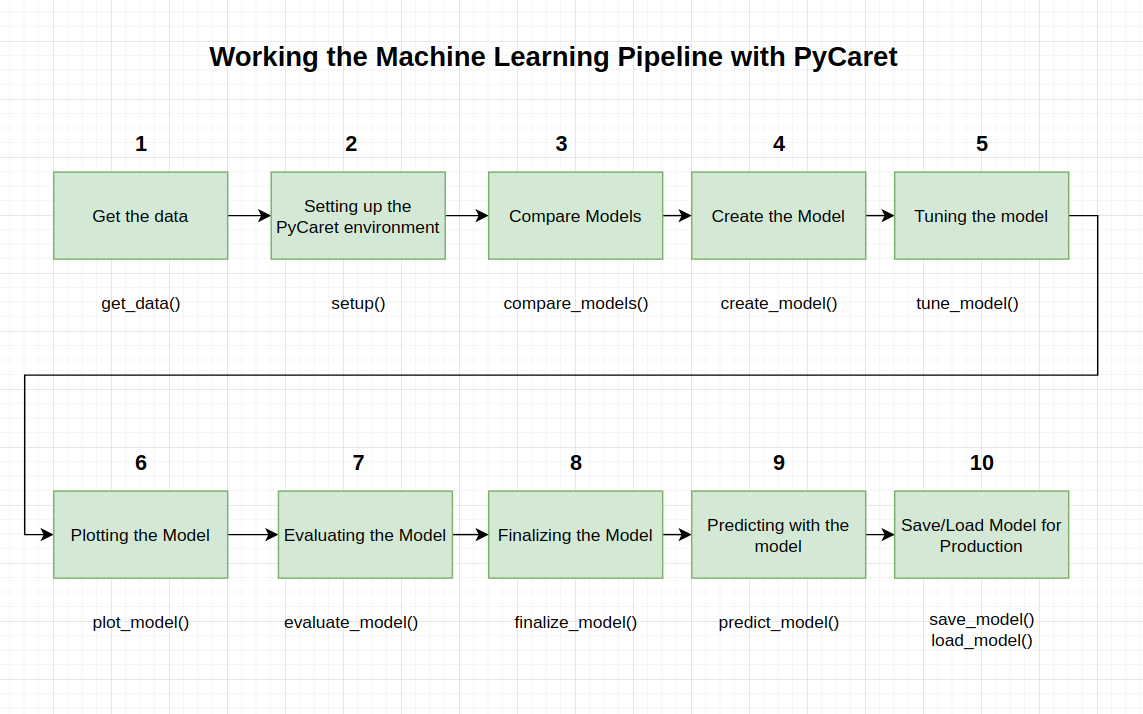

In [ ]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


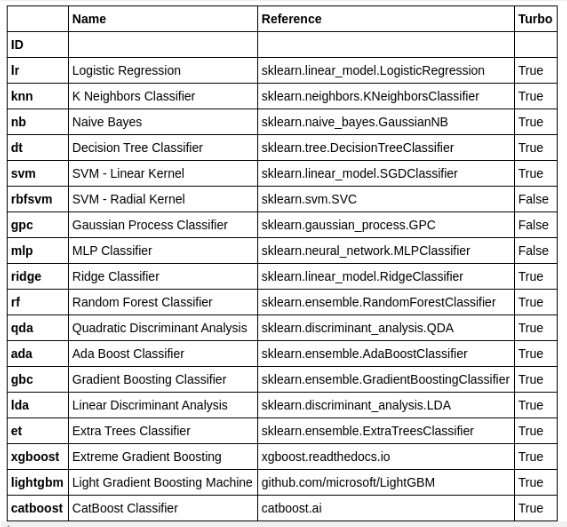

In [ ]:
## Config dict for reproducibility and to ensure PyCaret uses the seed to create a unique model over a differently split run of data
def setup_credit_config(seed):
    credit_config = {
        "target": "target",
        "session_id": seed,
        "silent": True,
        "normalize": True,
        "transformation": True,
        "ignore_low_variance": True,
        "remove_multicollinearity": True,
        "multicollinearity_threshold": 0.95,
        "bin_numeric_features": ['LIMIT_BAL', 'AGE'],
        "group_features": [['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'],
                          ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']],
        "experiment_name": f"credit_{seed}"
                     }
    return credit_config

In [ ]:
# Accessory function to call the collection of functions needed to convert useful information from the pycaret run into loggable artifacts for lineaging
def perform_experiment(exp):

    # Experiments are run by splitting a data into training and holdout internally, allowing their ability to make comparison

    # Runs an experiment which will compare different model types here and select the best model type
    best_model = compare_models()

    # Return the dataframe that shows the different metrics calculated for each of the tested model types
    leaderboard = get_leaderboard()
    # Get the internal names of the models for referential ID's in a DataFrame
    available_model_types = models()
    # Merge the above Dataframes
    model_comparison_results = leaderboard.reset_index().merge(available_model_types.reset_index(), left_on="Model Name", right_on="Name")

    # Takes the best model type from above and fine tune it to find the best hyperparameters, 
    # and collect useful information about the model during the tuning process
    tuned_finalized_model, tuned_model_results, tuner_cv_results = tune_and_finalize_model_with_metrics(best_model)
    return model_comparison_results, tuned_finalized_model, tuned_model_results, tuner_cv_results

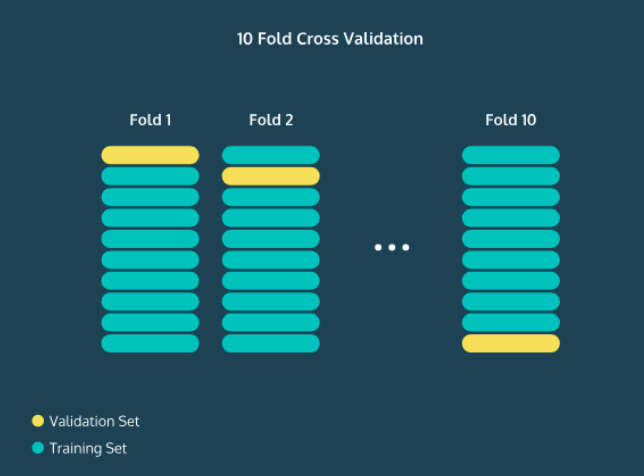

Internally this is what is occuring with the data that was allowed for training as shown in the sample split graphic.

Cross-validation uses different portions of data to test and train a model on different iterations to estimate how accurately a predictive model will perform in practice. 

In a prediction problem, a model is usually given a dataset of known data on which training is run (training dataset), and a dataset of unknown data (or first seen data) against which the model is tested (called the validation dataset or testing set). 

The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance production data).

One round of cross-validation involves partitioning a sample of data into complementary subsets, performing the analysis on one subset (called the training set), and validating the analysis on the other subset (called the validation set or testing set). To reduce variability, in most methods multiple rounds of cross-validation are performed using different partitions, and the validation results are combined (e.g. averaged) over the rounds to give an estimate of the model's predictive performance.

In summary, cross-validation combines (averages) measures of fitness in prediction to derive a more accurate estimate of model prediction performance.

In [ ]:
# Function to take a PyCaret model and generate an optimized model and the results of the optimization steps in dataframes
def tune_and_finalize_model_with_metrics(model):
    tuned_model, tuner = tune_model(model, return_tuner=True)
    #Pull collects the latest calculated table from output/experimentation into a dataframe
    #The pull after a tune_model call will return the details of optimization steps over a variety of metrics
    tuned_model_results = pull().reset_index()
    tuned_model_results["index"] = tuned_model_results["index"].astype(str)

    #The tuner cv results will return scores and more internal details of the model as it was tested over the optimization search schema
    tuner_cv_results = pd.DataFrame(tuner.cv_results_).reset_index()
    tuner_cv_results["index"]  = tuner_cv_results["index"].astype(str)

    #We finalize the model to train over the whole dataset (no holdout/validation dataset split)
    tuned_finalized_model = finalize_model(tuned_model)
    return tuned_finalized_model, tuned_model_results, tuner_cv_results

In [ ]:
import json
from pathlib import Path
from datetime import datetime

n=2
group_id = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
dataset_name = "credit"

for i in range(n):
    #Use seed to create a unique configuration for the current pycaret experiment
    seed = i + 1

    credit_config = setup_credit_config(seed) #Your specific configs for pycaret data preparation
    
    #Initialize wandb run to begin logging for pycaret experiment
    run = wandb.init(project="pycaret-example", reinit=True, config = credit_config, group=group_id,
               name=f"pycaret-example-seed-{seed}",
               notes=f"Seed {seed} of a run of Binary Classification of the`credit` dataset using pycaret utilizing wandb.ai")
    print(f"Seed: {seed}")
    # run.display(height=360)

    #Pull latest training data from wandb and load into df
    train_artifacts_path = run.use_artifact(f"{dataset_name}_train_data:latest").download()
    train_data_path = Path(train_artifacts_path, "train_data_table.table.json")
    train_data = load_wandb_table_artifact(train_data_path)

    #setup and run experiment
    credit_clf_exp = setup(data=train_data, **credit_config)
    model_comparison_results, tuned_finalized_model, tuned_model_results, tuner_cv_results = perform_experiment(credit_clf_exp)

    # save model
    model_title = f"pycaret-model-{group_id}-{seed}"
    save_model(tuned_finalized_model, model_title)

    # generate wandb tables from the results dfs from our experiment
    model_artifacts = wandb.Artifact(f"{dataset_name}_model_artifacts", type="model")
    model_comparison_results_table = pandas_to_wandb(model_comparison_results.drop(["Index", "Model", "Name"], axis=1))
    tuned_model_results_table = pandas_to_wandb(tuned_model_results)
    tuner_cv_results_table = pandas_to_wandb(tuner_cv_results)

    # add all objects to artifact
    model_artifacts.add(model_comparison_results_table, "model_comparison_results_table")
    model_artifacts.add(tuned_model_results_table, "tuned_model_results_table")
    model_artifacts.add(tuner_cv_results_table, "tuner_cv_results_table")
    model_artifacts.add_file(f"{model_title}.pkl", name="model.pkl")

    run.log_artifact(model_artifacts)

    run.finish()


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7763,0.6889,0.0084,0.7500,0.0165,0.0116,0.0630
1,0.7769,0.7051,0.0111,0.8000,0.0220,0.0159,0.0772
2,0.7744,0.7022,0.0084,0.4286,0.0164,0.0079,0.0324
3,0.7782,0.6982,0.0140,0.8333,0.0275,0.0202,0.0897
4,0.7763,0.6940,0.0168,0.5455,0.0325,0.0194,0.0641
5,0.7751,0.6907,0.0028,0.3333,0.0055,0.0018,0.0113
6,0.7757,0.6878,0.0084,0.5000,0.0165,0.0092,0.0406
7,0.7763,0.6897,0.0140,0.5556,0.0272,0.0164,0.0598
8,0.7794,0.6913,0.0223,0.8000,0.0435,0.0317,0.1096
9,0.7749,0.6921,0.0056,0.4000,0.0110,0.0049,0.0236


Transformation Pipeline and Model Successfully Saved


<a name="3"></a>
## 3: Detect Data Drift and Evaluate Models with W&B and Evidently

### [Evidently](https://docs.evidentlyai.com)
> Evidently helps evaluate machine learning models during validation and monitor them in production. The tool generates interactive visual reports and JSON profiles from pandas `DataFrame` or `csv` files. 

> You can use **visual reports** for ad hoc analysis, debugging and team sharing, and **JSON profiles** to integrate Evidently in prediction pipelines or with other visualization tools.

Currently 6 reports are available.  

1. Data Drift
Detects changes in feature distribution.

2. Numerical Target Drift
Detects changes in numerical target and feature behavior.

3. Categorical Target Drift
Detects changes in categorical target and feature behavior.

4. Regression Model Performance
Analyzes the performance of a regression model and model errors.

5. Classification Model Performance
Analyzes the performance and errors of a classification model. Works both for binary and multi-class models.

6. Probabilistic Classification Model Performance
Analyzes the performance of a probabilistic classification model, quality of model calibration, and model errors. Works both for binary and multi-class models.

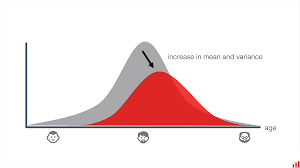

In [ ]:
from datetime import datetime
from pathlib import Path
import json 
from sklearn.metrics import classification_report
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, CatTargetDriftTab, ClassificationPerformanceTab

group_id = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
dataset_name = "credit"

In [ ]:
api = wandb.Api({"project": "pycaret-example"})
versions = api.artifact_versions("model", f"{dataset_name}_model_artifacts")
#Here is where we can apply other logic to investigate and filter all the models we would not want to evaluate
#For now we will assume every model from a run will be run against the evaluation data to be scored and promoted on

In [ ]:
for candidate in versions:
  run = wandb.init(project="pycaret-example", reinit=True, group=group_id,
               name=f"pycaret-evaluate-models",
               notes=f"Data drift and model analysis for promotion of models to production")
  # run.display(height=360)
  
  #Pull latest training data from wandb and load into df
  train_artifacts_path = run.use_artifact(f"{dataset_name}_train_data:latest").download()
  train_data_path = Path(train_artifacts_path, "train_data_table.table.json")
  train_data = load_wandb_table_artifact(train_data_path)

  #pull "production" data from wandb and load into df
  test_artifacts_path = run.use_artifact(f"{dataset_name}_test_data:latest").download()
  test_data_path = Path(test_artifacts_path, "test_data_table.table.json")
  test_data = load_wandb_table_artifact(test_data_path)

  #To prevent the original data from being mutated due to Evidently we save it into another object
  #This is not a necessary step
  ref_data = train_data.copy(deep=True)
  prod_data = test_data.copy(deep=True)

  #We add this use artifact step to ensure that W&B recongizes that this run has taken in this candidate artifact reference as an input
  candidate_artifact = run.use_artifact(candidate)
  model_path = candidate.get_path("model.pkl").download()
  candidate_model = load_model(model_path.replace(".pkl", ""))

  ref_data["prediction"] = predict_model(candidate_model, data = ref_data.drop(["target"], axis=1)).rename({"Label": "prediction"}, axis=1)["prediction"]
  prod_data["prediction"] = predict_model(candidate_model, data = prod_data.drop(["target"], axis=1)).rename({"Label": "prediction"}, axis=1)["prediction"]

  class_report_dict = classification_report(prod_data["target"], prod_data["prediction"], output_dict=True)
  candidate.metadata["evaluation_metrics"] = class_report_dict
                                                    
  data_and_target_drift_classification_report = Dashboard(tabs=[DataDriftTab, CatTargetDriftTab, ClassificationPerformanceTab])
  data_and_target_drift_classification_report.calculate(ref_data, prod_data)
  data_and_target_drift_classification_report.save("data_and_target_drift_classification_report.html")

  run.log({
      "data_and_target_drift_classification_report" : wandb.Html("data_and_target_drift_classification_report.html"), 
      "ref_eval" : wandb.Table(dataframe=prod_data[["target", "prediction"]]),
      "prod_eval" : wandb.Table(dataframe=ref_data[["target", "prediction"]])
  })
  candidate.save()
  run.finish()

wandb: WARNING Swapping artifacts does not support swapping artifacts used as an instance of `public.Artifact`. Using credit_model_artifacts:v1


Transformation Pipeline and Model Successfully Loaded


wandb: WARNING Swapping artifacts does not support swapping artifacts used as an instance of `public.Artifact`. Using credit_model_artifacts:v0


Transformation Pipeline and Model Successfully Loaded


<a name="4"></a>
## 4: Promote Model based on Evaluation Metric with W&B

> Note: [This feature is currently in beta](https://docs.wandb.ai/guides/models). Let us know what you think about it!

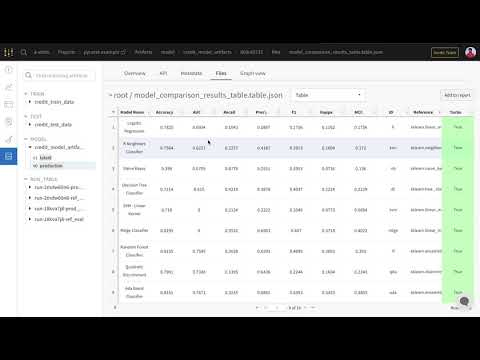

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("wfzTFcv89h0")

In [ ]:
#Iterable to serve as path keys for which to travese a nested dictionary
metric_chain = ["weighted avg", "f1-score"]
# metric_chain = ["accuracy"]

In [ ]:
api = wandb.Api({"project": "pycaret-example"})
versions = api.artifact_versions("model", f"{dataset_name}_model_artifacts")
#Same models as outlined above!

In [ ]:
best_metric = 0
best_candidate = None

for candidate in versions:

  # We will assume that the metadata of the candidate models will be within the key of "evaluation_metrics"
  # and will also be a nested dictionary to parse through for isolation of a desired metric to promot on
  evaluation_metrics = candidate.metadata.get("evaluation_metrics", {})
  current_metric = evaluation_metrics
  for metric_field in metric_chain:
    current_metric = current_metric.get(metric_field, {})
  
  print(f"{candidate.name} - {metric_chain}: {current_metric}")

  if current_metric > best_metric:
    best_metric = current_metric
    best_candidate = candidate

credit_model_artifacts:v1 - ['weighted avg', 'f1-score']: 0.7153120665742024
credit_model_artifacts:v0 - ['weighted avg', 'f1-score']: 0.820154595743122


In [ ]:
if (best_candidate is None):
  print("No valid model found")
else:
  if ('production' in best_candidate.aliases):
    print(f"Existing production model {best_candidate.name} has best score {best_metric} on {metric_chain}")
  else:
    print(f"Promoting model {best_candidate.name} which has best score {best_metric} on {metric_chain}")
best_candidate.aliases.append('production')
best_candidate.save()

Promoting model credit_model_artifacts:v0 which has best score 0.820154595743122 on ['weighted avg', 'f1-score']


True

## Aside: Let's look at our dashboards real quick!

In [ ]:
from datetime import datetime
group_id = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [ ]:
api = wandb.Api({"project": "pycaret-example"})
project = api.from_path("pycaret-example")
project.display(height=720)

True

<a name="5"></a>
## 5: Load promoted model to predict with W&B and PyCaret into FASTApi



In [ ]:
from datetime import datetime
group_id = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [ ]:
test_row = {"LIMIT_BAL":90000,
            "SEX":2,
            "EDUCATION":2,
            "MARRIAGE":2,
            "AGE":34,
            "PAY_1":0,
            "PAY_2":0,
            "PAY_3":0,
            "PAY_4":0,
            "PAY_5":0,
            "PAY_6":0,
            "BILL_AMT1":29239,
            "BILL_AMT2":14027,
            "BILL_AMT3":13559,
            "BILL_AMT4":14331,
            "BILL_AMT5":14948,
            "BILL_AMT6":15549,
            "PAY_AMT1":1518,
            "PAY_AMT2":1500,
            "PAY_AMT3":1000,
            "PAY_AMT4":1000,
            "PAY_AMT5":1000,
            "PAY_AMT6":5000,
            "target":0}

In [ ]:
!pip install -qqq colabcode fastapi

In [ ]:
from colabcode import ColabCode #sus package but using it for ease of setting up the usual ngrok business
from fastapi import FastAPI

In [ ]:
cc = ColabCode(port=12000, code=False)

In [ ]:
# app = FastAPI()

# @app.get("/")
# async def read_root():
#   return {"message": "Test entry point"}

In [ ]:
# #To test this still works
# cc.run_app(app=app)

In [ ]:
%%writefile models.py
from pydantic import BaseModel

class CreditData(BaseModel):
    LIMIT_BAL: int
    SEX: int
    EDUCATION: int
    MARRIAGE: int
    AGE: int
    PAY_1: int
    PAY_2: int
    PAY_3: int
    PAY_4: int
    PAY_5: int
    PAY_6: int
    BILL_AMT1: int
    BILL_AMT2: int
    BILL_AMT3: int
    BILL_AMT4: int
    BILL_AMT5: int
    BILL_AMT6: int
    PAY_AMT1: int
    PAY_AMT2: int
    PAY_AMT3: int
    PAY_AMT4: int
    PAY_AMT5: int
    PAY_AMT6: int


Overwriting models.py


In [ ]:
def get_prod_model_from_wandb(dataset_name, group_id):
    run = wandb.init(project="pycaret-example", reinit=False, group=group_id,
                name=f"pycaret-pull-production-model",
                notes=f"Grabbing of production tagged pycaret model")

    #The only real change needed here is that instead of `:latest` we use `:production` or whatever alias we set in our promotion phase
    prod_model_artifacts = run.use_artifact(f"{dataset_name}_model_artifacts:production")
    print(f"Loaded {prod_model_artifacts.name}")

    prod_model_path = prod_model_artifacts.get_path("model.pkl").download()
    run.finish()  

    return prod_model_path

In [ ]:
import logging
from fastapi import FastAPI
from models import CreditData
from pycaret.classification import *
import wandb
import time
from pathlib import Path

app = FastAPI(title="W&B ML Models as API on Google Colab", description="with FastAPI and ColabCode", version="1.0")
dataset_name = "credit"

model_path = get_prod_model_from_wandb(dataset_name, group_id) 
model = load_model(model_path.replace(".pkl", ""))

# model = None

# Here is how to load the model in a startup event
# @app.on_event("startup")
# def load_model():
#     global model

#     prod_model_path = get_prod_model_from_wandb(dataset_name, group_id)
#     model_path = Path(prod_model_path)
#     if model_path:
#         print(model_path)
#         model = load_model("./artifacts/credit_model_artifacts:v1/model")
#         # model = load_model(model_path.replace(".pkl", ""))
#     else:
#         print(model_path)

@app.post("/api", tags=["prediction"])
async def get_predictions(credit_data: CreditData):
    try:
        data = pd.DataFrame.from_dict([credit_data.dict()])
        prediction = predict_model(model, data = data).rename({"Label": "prediction"}, axis=1)["prediction"].tolist()[0]
        return {"prediction": prediction}
    except Exception as e:
        print(e.message)
        print(e.args)
        print("Something went wrong!")
        return {"prediction": "error"}

Loaded credit_model_artifacts:v0


Transformation Pipeline and Model Successfully Loaded


In [ ]:
# Uncomment to run FastAPI application!
# cc.run_app(app=app)

Note: Use the link from the `Ngroktunnel` and append on `/docs` to be able to see the resultant endpoint definition and be able to try your own values!